In [ ]:
import clip
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from forgery import *
from torchvision.utils import save_image
import torch.nn as nn
import numpy as np
from types import SimpleNamespace

class CLIPFeatureExtractor:
    def __init__(self, model_name="ViT-B/32", device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model, self.preprocess = clip.load(model_name, device=self.device)
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad_(False)

    def preprocess_image(self, img):
        if isinstance(img, Image.Image):
            return self.preprocess(img).unsqueeze(0).to(self.device)
        elif isinstance(img, torch.Tensor):
            if img.dim() == 3:
                img = img.unsqueeze(0)
            img = F.interpolate(img.float(), size=(224, 224), mode='bicubic', align_corners=False)
            return img.to(self.device)
        else:
            raise TypeError("Input must be PIL.Image or torch.Tensor")

    def encode(self, img, no_grad=True):
        img_input = self.preprocess_image(img)
        if no_grad:
            with torch.no_grad():
                features = self.model.encode_image(img_input)
        else:
            features = self.model.encode_image(img_input)
        # return F.normalize(features.float(), dim=-1)
        return features.float()

    def compare(self, img1, img2):
        f1 = self.encode(img1)
        f2 = self.encode(img2)
        cos_sim = torch.sum(f1 * f2, dim=-1).item()
        l2_dist = torch.norm(f1 - f2, dim=-1).item()
        return cos_sim, l2_dist


In [ ]:


args = SimpleNamespace(
    r=2,
    lr=0.1,
    epsilon=0.01,
    iteration=500
)

In [9]:
orig_path = "/work/forgery/Data/StableSignature2/original/img_5768.png"
wm_path = "/work/forgery/Data/StableSignature2/watermarked/img_5768.png"

key = '111010110101000001010111010011010100010000100111' 

msg_extractor = torch.jit.load("models/dec_48b_whit.torchscript.pt").to("cuda")
to_tensor = transforms.Compose([
    transforms.ToTensor(),  
])

img1 = to_tensor(Image.open(orig_path)).unsqueeze(0).float()
img2 = to_tensor(Image.open(wm_path)).unsqueeze(0).float()

extractor = CLIPFeatureExtractor()
criterion = nn.MSELoss().cuda()

bit_acc_groundtruth, bound, success,adv_img,acc_list,diff_list = Forgery_no_box(img1, img2,key, criterion, msg_extractor,extractor,args)

save_image(adv_img, "forged_img.png")
print("🖼️ forged_img.png saved.")

iteration:0           diff:0.0037174641620367765     bit_acc_target:0.39583333333333337
iteration:1           diff:0.0035404975060373545     bit_acc_target:0.39583333333333337
iteration:2           diff:0.0034036904107779264     bit_acc_target:0.39583333333333337
iteration:3           diff:0.003273848444223404     bit_acc_target:0.39583333333333337
iteration:4           diff:0.003168001538142562     bit_acc_target:0.39583333333333337
iteration:5           diff:0.0030660603661090136     bit_acc_target:0.39583333333333337
iteration:6           diff:0.0029739211313426495     bit_acc_target:0.39583333333333337
iteration:7           diff:0.002895452082157135     bit_acc_target:0.39583333333333337
iteration:8           diff:0.002841098001226783     bit_acc_target:0.39583333333333337
iteration:9           diff:0.0027490733191370964     bit_acc_target:0.39583333333333337
iteration:10           diff:0.002693378832191229     bit_acc_target:0.39583333333333337
iteration:11           diff:0.002626

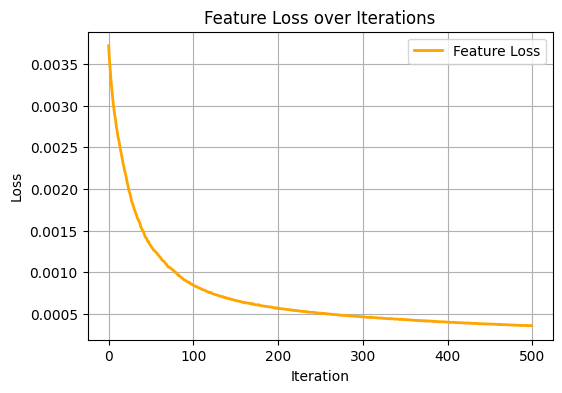

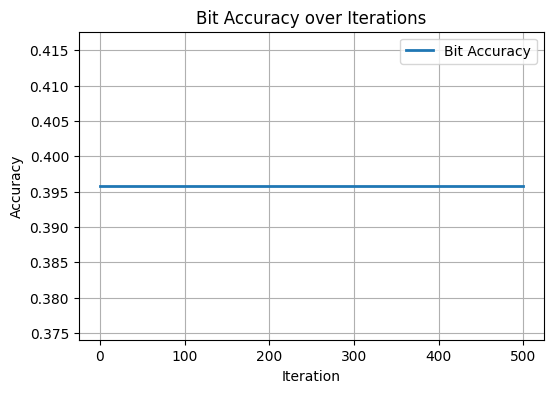

In [10]:
import matplotlib.pyplot as plt
# Feature Loss 
plt.figure(figsize=(6, 4))
plt.plot(diff_list, label="Feature Loss", color='orange', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Feature Loss over Iterations")
plt.grid(True)
plt.legend()
plt.show()

# Bit Accuracy 
plt.figure(figsize=(6, 4))
plt.plot(acc_list, label="Bit Accuracy", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Bit Accuracy over Iterations")
plt.grid(True)
plt.legend()
plt.show()

